In [107]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
import pdb
from collections import defaultdict
### These imports give fit_transform method for free ###
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import pdb
from collections import defaultdict
import pickle

In [3]:
# import the scikit-learn compatible transformer pipeline ##
#from simformer import SimFormer

In [108]:
datapath = r'..\Data\sampled_df.csv'


In [109]:
from featurewiz import FeatureWiz

In [110]:
### Once the SimFormer pipeline is built, it can work with Featurewiz ##
#smp = SimFormer(with_model=False, date_to_string=False)
FW = FeatureWiz()

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        


In [111]:
target = 'churned'
modeltype = 'Classification'

In [112]:

df = pd.read_csv(r'..\Data\sampled_df.csv')

if isinstance(target, str):
    cols = [x for x in list(df) if x not in [target]]
else:
    cols = [x for x in list(df) if x not in target]
X = df[cols]
X = X.drop(columns=['customer_id','date','start_balance','state','days_since_last_active_transaction'])
y = df[target]
X.head()

,amount,interaction_count,active_interaction_count,age,account_maturity,current_balance,FEDFUNDS,GDP_PCH,Inflation,previous_balance,big_withdraw,neg_growth,isCalifornia,isTexas
0,0.00,3,0.0,13.75,0.16,7919.64,5.26,1.25425,3.109001,7919.64,False,0,True,False
1,0.00,1,0.0,22.32,1.16,10420.62,2.61,-0.05790,2.688766,10420.62,False,1,False,False
2,-1769.89,4,4.0,20.03,0.83,7654.18,4.49,1.03639,2.656370,9424.07,True,0,False,False
3,0.00,1,0.0,26.61,0.75,10882.96,4.76,1.03639,2.503325,10882.96,False,0,False,False
4,0.00,1,0.0,38.40,1.58,24945.97,2.00,0.22399,3.084506,24945.97,False,0,True,False


In [113]:
from sklearn.model_selection import train_test_split
if modeltype == 'Regression':
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=999)
else:
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,stratify=y, random_state=999)
print(X_train.shape, X_test.shape)

(185103, 14) (20567, 14)


In [12]:
### This returns a transformer + feature selection pipeline once you fit it ###
#mlp = smp.fit(X_train, y_train)
#FW.fit(X_train, y_train)

In [83]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
#import optuna
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
pipe = Pipeline([('fw', FeatureWiz()),('classifier', RandomForestClassifier())])
param_grid = {'classifier__bootstrap': [True],
                'classifier__n_estimators':[174],
                'classifier__max_depth': [6],
                'classifier__max_features': ['log2'],
                'classifier__min_samples_leaf': [44],
                'classifier__min_samples_split': [26]}
search = RandomizedSearchCV(estimator=pipe,
                            param_distributions=param_grid,
                            scoring='recall',
                            n_iter=3,
                            n_jobs=-1,
                            random_state=99,
                            cv=3,
                            error_score=1)

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        


wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
 

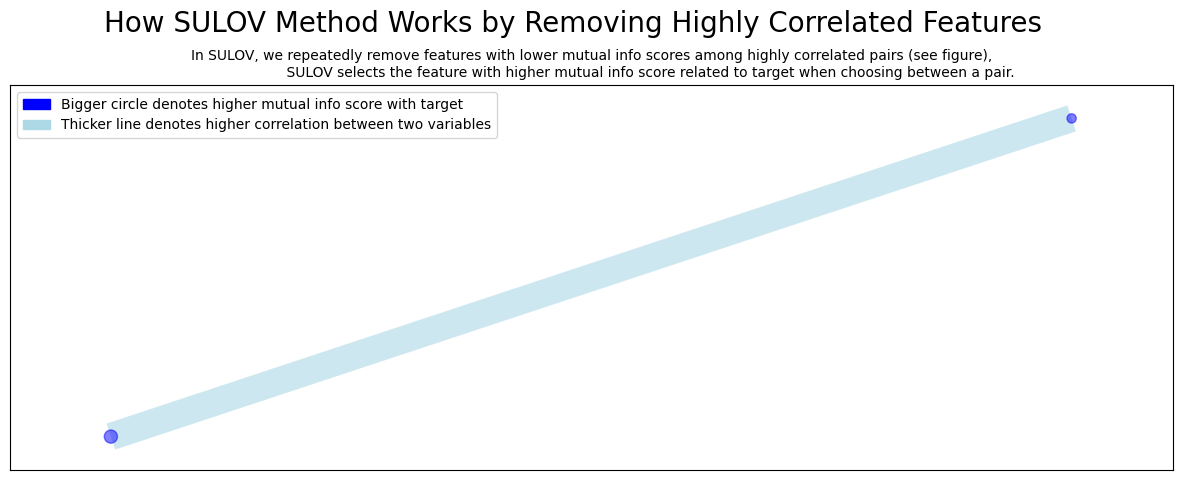

Time taken for SULOV method = 2 seconds
    Adding 3 categorical variables to reduced numeric variables  of 10
Final list of selected 13 vars after SULOV = ['FEDFUNDS', 'GDP_PCH', 'Inflation', 'account_maturity', 'active_interaction_count', 'age', 'amount', 'interaction_count', 'neg_growth', 'current_balance', 'big_withdraw', 'isCalifornia', 'isTexas']
Converting all features to numeric before sending to XGBoost...
    there were no mixed data types or object columns that errored. Data is all numeric...
Shape of train data after adding missing values flags = (185103, 14)
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 13 
    Taking top 3 features per iteration...
    XGBoost version using 1.7

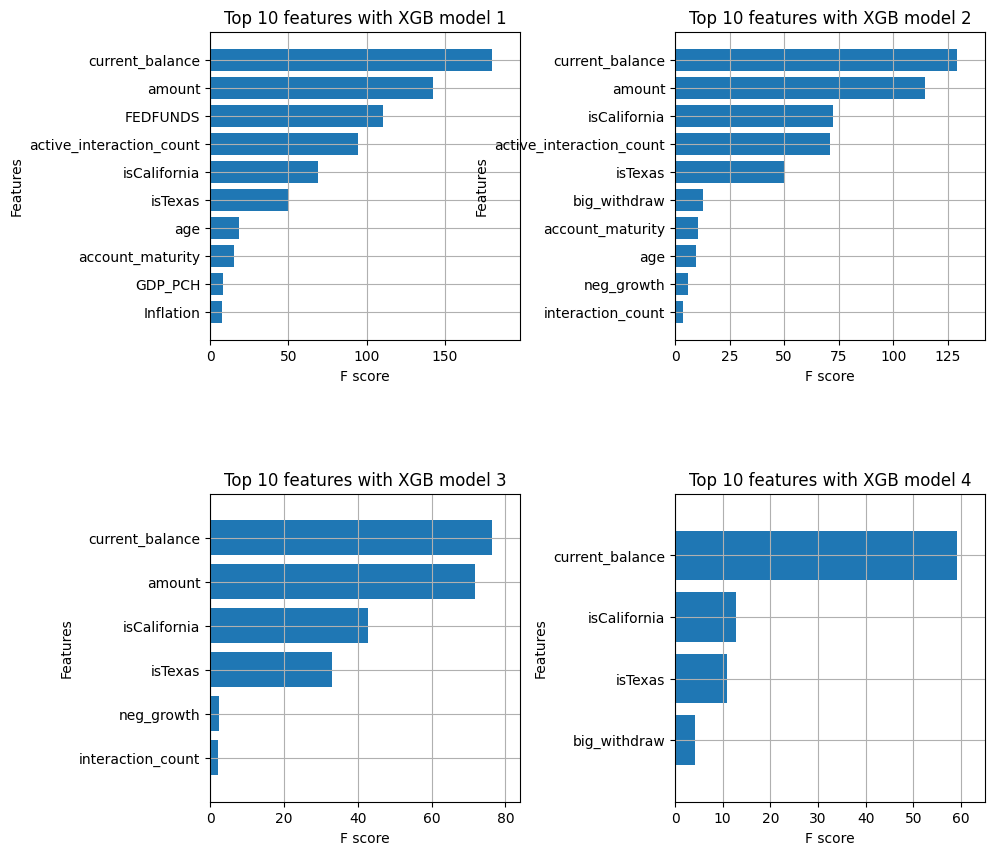

    Completed XGBoost feature selection in 0 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 6 important features:
['current_balance', 'amount', 'FEDFUNDS', 'active_interaction_count', 'isCalifornia', 'isTexas']
Total Time taken for featurewiz selection = 4 seconds
Output contains a list of 6 important features and a train dataframe
    Time taken to create entire pipeline = 4 second(s)


RandomizedSearchCV(cv=3, error_score=1,
                   estimator=Pipeline(steps=[('fw', FeatureWiz()),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True],
                                        'classifier__max_depth': [6],
                                        'classifier__max_features': ['log2'],
                                        'classifier__min_samples_leaf': [44],
                                        'classifier__min_samples_split': [26],
                                        'classifier__n_estimators': [174]},
                   random_state=99, scoring='recall')

In [85]:
search.fit(X_train, y_train)

In [19]:
from sklearn.metrics import precision_recall_curve, f1_score, balanced_accuracy_score, accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import optuna

def objective(trial):
    max_features = trial.suggest_categorical('max_features', ['sqrt','log2'])
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 8)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    model = RandomForestClassifier(
            max_features=max_features,
            n_estimators=n_estimators,
            max_depth = max_depth,
            min_samples_leaf = min_samples_leaf,
            min_samples_split= min_samples_split
        )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    return recall
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f'    {key}: {value}')
model_opt = RandomForestClassifier(
    n_estimators=trial.params['n_estimators'],
    max_depth=trial.params['max_depth'],
    min_samples_leaf=trial.params['min_samples_leaf'],
    min_samples_split=trial.params['min_samles_split'],
    max_features=trial.params['max_features']
)
model_opt.fit(X_train, y_train)
y_pred = model_opt.predict(X_test)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
bas = balanced_accuracy_score(y_test, y_pred)
print(
    f'Performance Metrics:\nrecall score: {recall:.3f}\nf1 score: {f1:.3f}\nbalanced accuracy score: {bas:.3f}')

[I 2023-03-02 10:52:01,973] A new study created in memory with name: no-name-81e17cb6-140a-4cdd-bd5b-d5c4a26bb27d
[I 2023-03-02 10:52:17,994] Trial 0 finished with value: 0.7074397126731657 and parameters: {'max_features': 'log2', 'n_estimators': 156, 'max_depth': 6, 'min_samples_leaf': 41, 'min_samples_split': 50}. Best is trial 0 with value: 0.7074397126731657.
[I 2023-03-02 10:53:00,177] Trial 1 finished with value: 0.7051821446895844 and parameters: {'max_features': 'log2', 'n_estimators': 346, 'max_depth': 8, 'min_samples_leaf': 28, 'min_samples_split': 30}. Best is trial 0 with value: 0.7074397126731657.
[I 2023-03-02 10:53:27,615] Trial 2 finished with value: 0.6266803488968702 and parameters: {'max_features': 'sqrt', 'n_estimators': 482, 'max_depth': 3, 'min_samples_leaf': 27, 'min_samples_split': 49}. Best is trial 0 with value: 0.7074397126731657.
[I 2023-03-02 10:54:02,624] Trial 3 finished with value: 0.7012827090815803 and parameters: {'max_features': 'sqrt', 'n_estimators

KeyboardInterrupt: 

In [62]:
from sklearn.metrics import precision_recall_curve, f1_score, balanced_accuracy_score, accuracy_score, recall_score, fbeta_score, precision_score
def f3_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return (1.3 * precision * recall) / (0.3 * precision + recall)
model = RandomForestClassifier(
            max_features='log2',
            n_estimators=174,
            max_depth = 6,
            min_samples_leaf = 44,
            min_samples_split= 26
        )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
bas = balanced_accuracy_score(y_test, y_pred)
f3 = f3_score(y_test, y_pred)
print(
    f'Performance Metrics:\nrecall score: {recall:.3f}\nf1 score: {f1:.3f}\nbalanced accuracy score: {bas:.3f}')
print(precision, accuracy,f3)

Performance Metrics:
recall score: 0.000
f1 score: 0.000
balanced accuracy score: 0.500
0.0 0.9541702918146119 nan


In [49]:
def f3_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return (1.3 * precision * recall) / (0.3 * precision + recall)


In [114]:
from sklearn.metrics import precision_recall_curve, f1_score, balanced_accuracy_score, accuracy_score, recall_score, fbeta_score, precision_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import optuna

def f3_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return (1.3 * precision * recall) / (0.3 * precision + recall)

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 150, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 0.1),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.1, 1.0)
    }
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    return recall
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f'    {key}: {value}')
model_opt = xgb.XGBClassifier(
    n_estimators=trial.params['n_estimators'],
    max_depth=trial.params['max_depth'],
    learning_rate=trial.params['learning_rate'],
    min_child_weight = trial.params['min_child_weight'],
    gamma=trial.params['gamma'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree']
)

model_opt.fit(X_train, y_train)
y_pred = model_opt.predict(X_test)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
bas = balanced_accuracy_score(y_test, y_pred)
print(
    f'Performance Metrics:\nrecall score: {recall:.3f}\nf1 score: {f1:.3f}\nbalanced accuracy score: {bas:.3f}')

[I 2023-03-02 16:59:41,168] A new study created in memory with name: no-name-5a93053b-981d-4499-9453-0bbcbe374cf2
[I 2023-03-02 17:00:03,776] Trial 0 finished with value: 0.6816104249732569 and parameters: {'max_depth': 8, 'learning_rate': 0.06863585052689246, 'n_estimators': 361, 'min_child_weight': 1, 'gamma': 2.0148986726137264e-05, 'subsample': 0.577155803633188, 'colsample_bytree': 0.24659755072776088}. Best is trial 0 with value: 0.6816104249732569.
[I 2023-03-02 17:00:12,356] Trial 1 finished with value: 0.685500340367597 and parameters: {'max_depth': 7, 'learning_rate': 0.01977202130184249, 'n_estimators': 343, 'min_child_weight': 1, 'gamma': 6.386389584043124e-06, 'subsample': 0.016581973119451077, 'colsample_bytree': 0.13325777522436497}. Best is trial 1 with value: 0.685500340367597.
[I 2023-03-02 17:00:22,335] Trial 2 finished with value: 0.6786929884275017 and parameters: {'max_depth': 5, 'learning_rate': 0.021656449987933483, 'n_estimators': 327, 'min_child_weight': 4, 'g

KeyboardInterrupt: 

In [115]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score


print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f'    {key}: {value}')
model_opt = xgb.XGBClassifier(
    n_estimators=trial.params['n_estimators'],
    max_depth=trial.params['max_depth'],
    learning_rate=trial.params['learning_rate'],
    min_child_weight = trial.params['min_child_weight'],
    gamma=trial.params['gamma'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree']
)

model_opt.fit(X_train, y_train)
y_pred = model_opt.predict(X_test)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
bas = balanced_accuracy_score(y_test, y_pred)
f3 = f3_score(y_test, y_pred)
print(
    f'Performance Metrics:\nrecall score: {recall:.3f}\nf1 score: {f1:.3f}\nbalanced accuracy score: {bas:.3f}')
print(precision, accuracy,)

Best trial:
  Value:  0.7099095594670816
  Params: 
    max_depth: 5
    learning_rate: 0.010233267090074893
    n_estimators: 183
    min_child_weight: 3
    gamma: 0.03928904985283722
    subsample: 0.5168624001147734
    colsample_bytree: 0.25524501485728796
Performance Metrics:
recall score: 0.710
f1 score: 0.672
balanced accuracy score: 0.653
0.6373319364414178 0.6529877959838576


In [117]:
miri

,Unnamed: 0,amount,start_balance,interaction_count,active_interaction_count,age,account_maturity,current_balance,FEDFUNDS,GDP_PCH,Inflation,days_since_last_active_transaction,previous_balance,big_withdraw,neg_growth,isCalifornia,isTexas
0,516,2140.17,8903.92,5,5.0,30.21,13.33,45671.09,0.05,-8.82764,2.084208,3.0,43530.92,False,1,False,True
1,1411,508.27,1851.12,2,1.0,36.20,13.33,11939.31,0.05,-8.82764,2.084208,0.0,11431.04,False,1,False,False
2,1591,1671.24,7357.40,3,3.0,41.76,13.33,36749.29,0.05,-8.82764,2.084208,8.0,35078.05,False,1,False,True
3,4278,2272.39,6425.40,3,1.0,56.51,13.33,53128.57,0.05,-8.82764,2.084208,0.0,50856.18,False,1,False,False
4,5534,2285.85,7929.40,1,1.0,43.39,13.33,58310.74,0.05,-8.82764,2.084208,0.0,56024.89,False,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17238,115996,-350.95,3110.96,2,2.0,51.25,0.00,2760.01,0.05,-8.82764,2.084208,19.0,3110.96,False,1,False,False
17239,115997,-1003.22,12063.92,3,3.0,53.60,0.00,11060.70,0.05,-8.82764,2.084208,22.0,12063.92,True,1,False,False
17240,115998,-1102.10,11011.36,2,2.0,34.09,0.00,9909.26,0.05,-8.82764,2.084208,2.0,11011.36,True,1,False,False
17241,115999,2246.93,8861.08,1,1.0,36.77,0.00,11108.01,0.05,-8.82764,2.084208,0.0,8861.08,False,1,False,False


In [116]:
miri = pd.read_csv(r'..\Data\miri_test_set.csv')

y_pred = model_opt.predict(miri)
miri_r_xgb = model_opt.predict_proba(miri)

ValueError: Feature shape mismatch, expected: 14, got 17

In [56]:
y_pred = model_opt.predict(X_test)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
bas = balanced_accuracy_score(y_test, y_pred)
f3 = f3_score(y_test, y_pred)
print(
    f'Performance Metrics:\nrecall score: {recall:.3f}\nf1 score: {f1:.3f}\nbalanced accuracy score: {bas:.3f}')
print(precision, accuracy, f3)

Performance Metrics:
recall score: 0.717
f1 score: 0.674
balanced accuracy score: 0.653
0.635999635999636 0.6533606977937404 0.6530601976639713


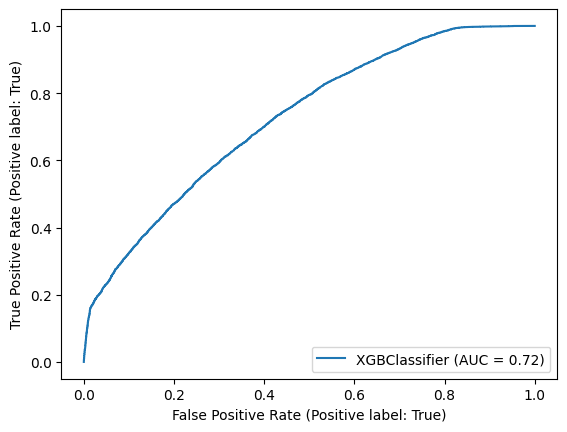

In [44]:
from sklearn.metrics import plot_roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn import metrics
metrics.plot_roc_curve(model_opt, X_test, y_test) 
plt.show()

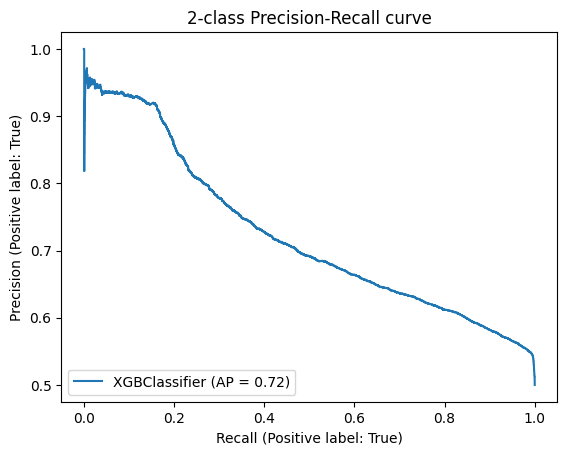

In [45]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    model_opt, X_test, y_test
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

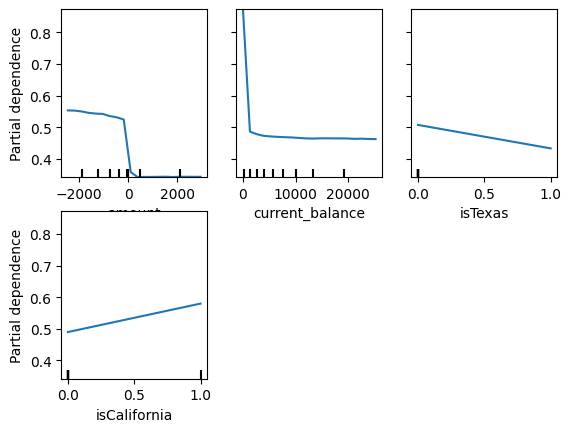

In [48]:
from sklearn.inspection import plot_partial_dependence
features = ['amount', 'current_balance', 'isTexas', 'isCalifornia']
plot_partial_dependence(model_opt, X_train, features, n_jobs=3, grid_resolution=20)
fig = plt.gcf()

In [30]:
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f'    {key}: {value}')
model_opt = RandomForestClassifier(
    n_estimators=trial.params['n_estimators'],
    max_depth=trial.params['max_depth'],
    min_samples_leaf=trial.params['min_samples_leaf'],
    min_samples_split=trial.params['min_samples_split'],
    max_features=trial.params['max_features']
)
model_opt.fit(X_train, y_train)
y_pred = model_opt.predict(X_test)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
bas = balanced_accuracy_score(y_test, y_pred)
print(
    f'Performance Metrics:\nrecall score: {recall:.3f}\nf1 score: {f1:.3f}\nbalanced accuracy score: {bas:.3f}')

Best trial:
  Value:  0.7155464340687532
  Params: 
    max_depth: 5
    learning_rate: 0.012275135058397427
    n_estimators: 438
    min_child_weight: 8
    gamma: 0.0003558827937065251
    subsample: 0.38918125076457466
    colsample_bytree: 0.703902281892418


KeyError: 'min_samples_leaf'

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
 

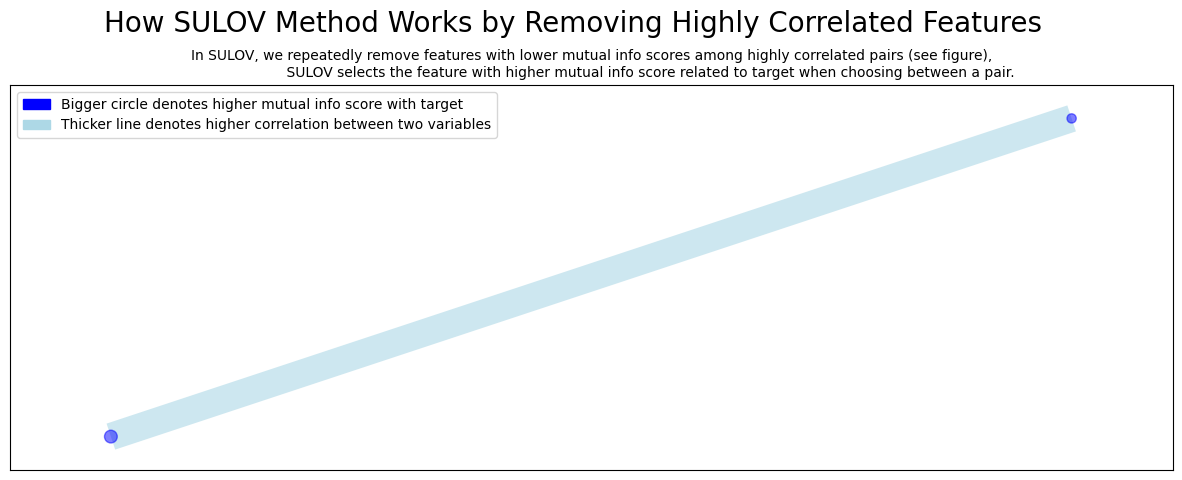

Time taken for SULOV method = 2 seconds
    Adding 3 categorical variables to reduced numeric variables  of 10
Final list of selected 13 vars after SULOV = ['FEDFUNDS', 'GDP_PCH', 'Inflation', 'account_maturity', 'active_interaction_count', 'age', 'amount', 'interaction_count', 'neg_growth', 'current_balance', 'big_withdraw', 'isCalifornia', 'isTexas']
Converting all features to numeric before sending to XGBoost...
    there were no mixed data types or object columns that errored. Data is all numeric...
Shape of train data after adding missing values flags = (175402, 14)
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 13 
    Taking top 3 features per iteration...
    XGBoost version using 1.7

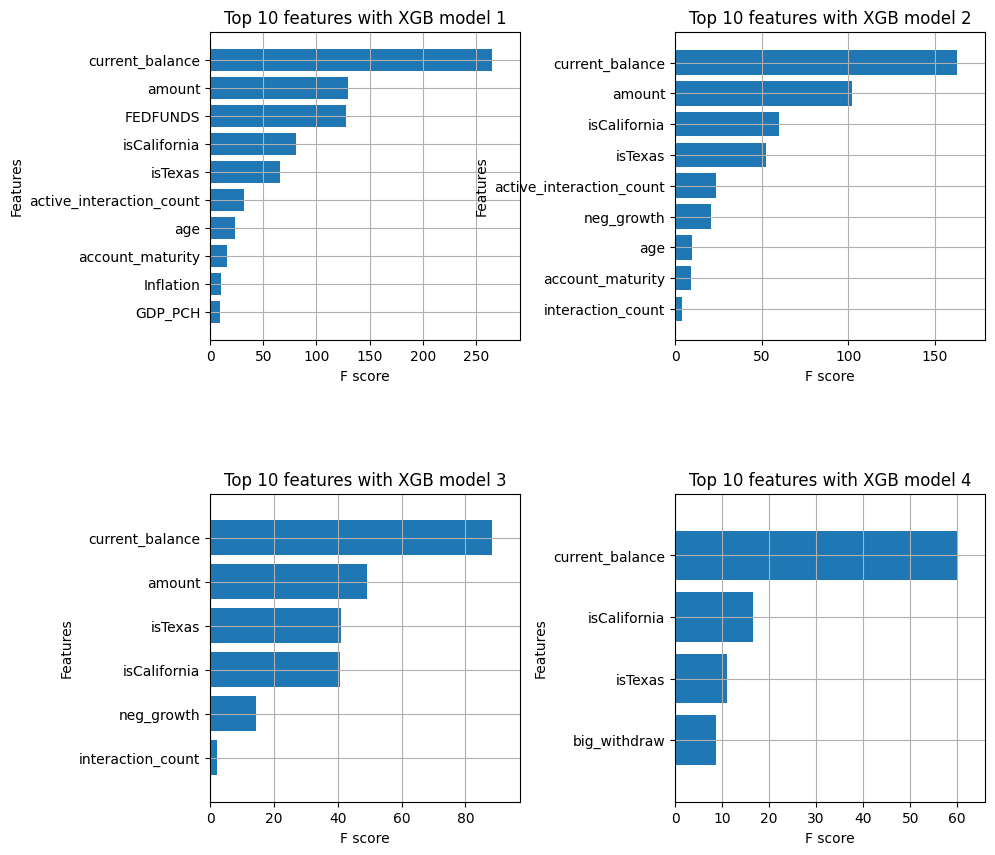

    Completed XGBoost feature selection in 0 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 6 important features:
['current_balance', 'amount', 'FEDFUNDS', 'isCalifornia', 'isTexas', 'active_interaction_count']
Total Time taken for featurewiz selection = 4 seconds
Output contains a list of 6 important features and a train dataframe
    Time taken to create entire pipeline = 4 second(s)


RandomizedSearchCV(cv=3, error_score=1,
                   estimator=Pipeline(steps=[('fw', FeatureWiz()),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True],
                                        'classifier__max_depth': [5],
                                        'classifier__max_features': ['log2'],
                                        'classifier__min_samples_leaf': [40],
                                        'classifier__min_samples_split': [25],
                                        'classifier__n_estimators': [192]},
                   random_state=99, scoring='recall')

In [21]:
search.fit(X_train, y_train)

In [22]:
y_pred = search.predict(X_test)
y_pred.shape

(19490,)

In [22]:
y_train.value_counts()

False    1826012
True       87701
Name: will_churn, dtype: int64

In [92]:
miri = pd.read_csv(r'..\Data\miri_test_set.csv')

In [118]:
miri.drop(columns=['days_since_last_active_transaction','Unnamed: 0'],inplace=True)

In [119]:
miri

,amount,start_balance,interaction_count,active_interaction_count,age,account_maturity,current_balance,FEDFUNDS,GDP_PCH,Inflation,previous_balance,big_withdraw,neg_growth,isCalifornia,isTexas
0,2140.17,8903.92,5,5.0,30.21,13.33,45671.09,0.05,-8.82764,2.084208,43530.92,False,1,False,True
1,508.27,1851.12,2,1.0,36.20,13.33,11939.31,0.05,-8.82764,2.084208,11431.04,False,1,False,False
2,1671.24,7357.40,3,3.0,41.76,13.33,36749.29,0.05,-8.82764,2.084208,35078.05,False,1,False,True
3,2272.39,6425.40,3,1.0,56.51,13.33,53128.57,0.05,-8.82764,2.084208,50856.18,False,1,False,False
4,2285.85,7929.40,1,1.0,43.39,13.33,58310.74,0.05,-8.82764,2.084208,56024.89,False,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17238,-350.95,3110.96,2,2.0,51.25,0.00,2760.01,0.05,-8.82764,2.084208,3110.96,False,1,False,False
17239,-1003.22,12063.92,3,3.0,53.60,0.00,11060.70,0.05,-8.82764,2.084208,12063.92,True,1,False,False
17240,-1102.10,11011.36,2,2.0,34.09,0.00,9909.26,0.05,-8.82764,2.084208,11011.36,True,1,False,False
17241,2246.93,8861.08,1,1.0,36.77,0.00,11108.01,0.05,-8.82764,2.084208,8861.08,False,1,False,False


In [120]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score

y_pred = model_opt.predict(miri)

probs = model_opt.predict_proba(miri)

# print(balanced_accuracy_score(y_test, y_pred))
# print(precision_score(y_test, y_pred))
# print(recall_score(y_test, y_pred))
# print(f1_score(y_test, y_pred))
# print(roc_auc_score(y_test, y_pred))

# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(cm)
# disp.plot()

ValueError: Feature shape mismatch, expected: 14, got 15

In [102]:
miri_results = probs[:,1]

In [103]:
miri_r = pd.DataFrame(miri_results)

In [106]:
miri_r.to_csv(r'..\Data\miri_res.csv')

In [23]:
search.best_estimator_


Pipeline(steps=[('fw', FeatureWiz()),
                ('classifier',
                 RandomForestClassifier(max_features='auto',
                                        min_samples_leaf=4))])

In [24]:
unsampled = pd.read_csv(r'..\Data\unsampled_df.csv')

In [25]:

X = unsampled.drop(columns=['customer_id','date','start_balance','state','days_since_last_active_transaction',target])
y = unsampled[target]

In [36]:
y_pred2 = search.predict(X)

In [37]:
print(balanced_accuracy_score(y, y_pred2))
print(precision_score(y, y_pred2))
print(recall_score(y, y_pred2))
print(f1_score(y, y_pred2))
print(roc_auc_score(y, y_pred2))

0.7620310572943985
0.10502517202503596
0.8871580157215279
0.18781596859378089
0.7620310572943986


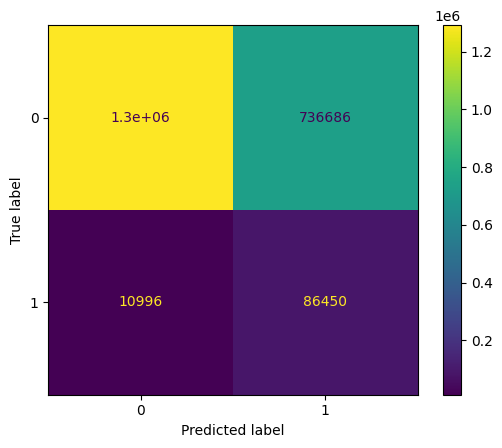

In [38]:
cm = confusion_matrix(y, y_pred2)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score


model = RandomForestClassifier(
            max_features='sqrt',
            n_estimators=100,
            max_depth = 8,
            min_samples_leaf = 4,
            min_samples_split= 8
        )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
recall = recall_score(y_test, y_pred)

print(balanced_accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

0.6482811698306824
0.6334010339734121
0.7040533606977938
0.6668610584633329
0.6482811698306825
